Starting main function...
Loading datasets...
Data loaded successfully.
Fraud_Data Missing Values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Creditcard Missing Values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Data cleaned.
Performing EDA...


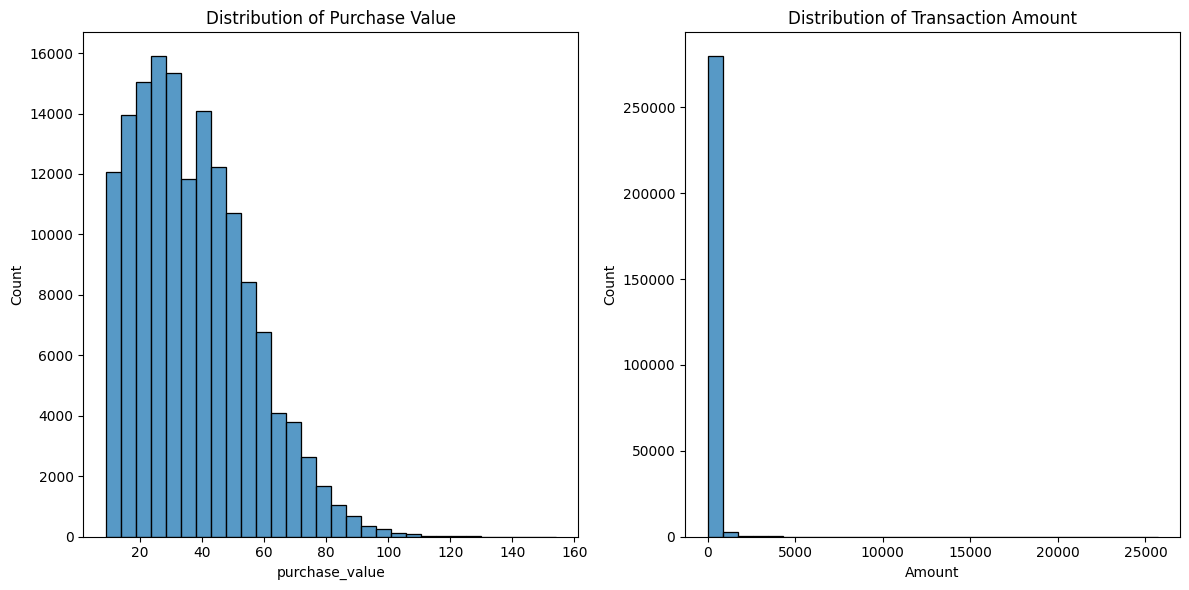

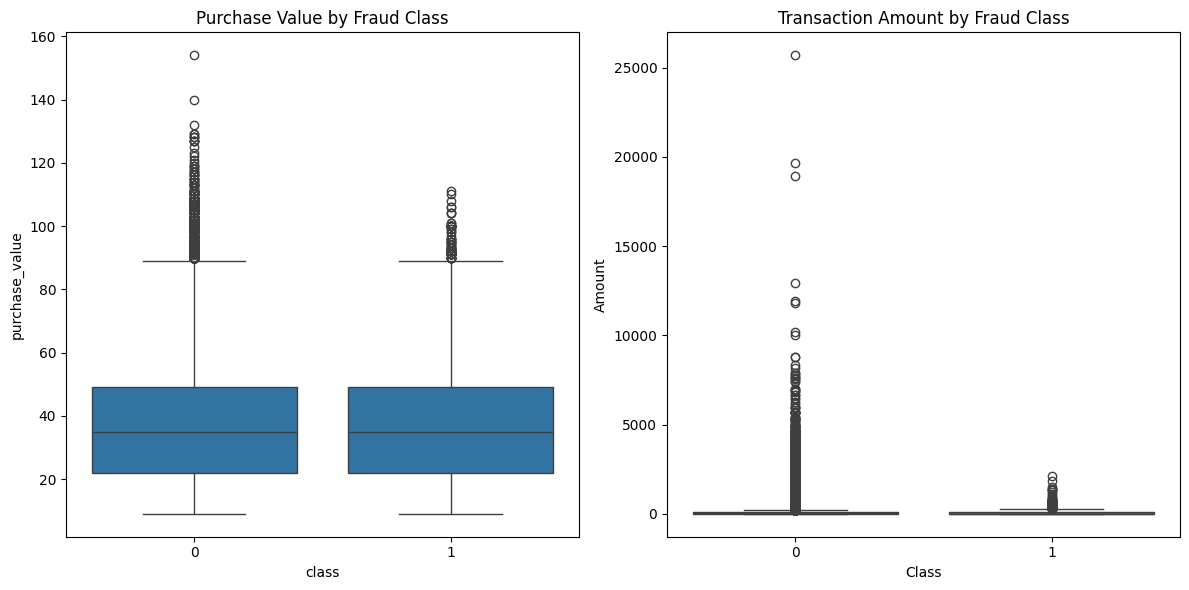

EDA completed, plots saved.
Merging geolocation data...
Geolocation merged.
Performing feature engineering...
Feature engineering completed.
Transforming data...
Handling class imbalance...


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Handling class imbalance...
Data transformation completed.
Output files saved in /content/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load Data
def load_data():
    print("Loading datasets...", flush=True)
    fraud_data = pd.read_csv('/content/Fraud_Data.csv')
    ip_to_country = pd.read_csv('/content/IpAddress_to_Country.csv')
    creditcard_data = pd.read_csv('/content/creditcard.csv')
    return fraud_data, ip_to_country, creditcard_data

# 2. Handle Missing Values and Data Cleaning
def clean_data(fraud_data, creditcard_data):
    print("Fraud_Data Missing Values:\n", fraud_data.isnull().sum(), flush=True)
    fraud_data = fraud_data.dropna()
    fraud_data = fraud_data.drop_duplicates()
    fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
    fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

    print("Creditcard Missing Values:\n", creditcard_data.isnull().sum(), flush=True)
    creditcard_data = creditcard_data.dropna()
    creditcard_data = creditcard_data.drop_duplicates()

    return fraud_data, creditcard_data

# 3. Exploratory Data Analysis (EDA)
def perform_eda(fraud_data, creditcard_data):
    print("Performing EDA...", flush=True)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(fraud_data['purchase_value'], bins=30)
    plt.title('Distribution of Purchase Value')
    plt.subplot(1, 2, 2)
    sns.histplot(creditcard_data['Amount'], bins=30)
    plt.title('Distribution of Transaction Amount')
    plt.tight_layout()
    plt.savefig('/content/univariate_distributions.png')
    plt.show()
    plt.close()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='class', y='purchase_value', data=fraud_data)
    plt.title('Purchase Value by Fraud Class')
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Class', y='Amount', data=creditcard_data)
    plt.title('Transaction Amount by Fraud Class')
    plt.tight_layout()
    plt.savefig('/content/bivariate_boxplots.png')
    plt.show()
    plt.close()

# 4. Merge Datasets for Geolocation Analysis
def merge_geolocation(fraud_data, ip_to_country):
    print("Merging geolocation data...", flush=True)
    fraud_data['ip_address'] = pd.to_numeric(fraud_data['ip_address'], errors='coerce').fillna(0).astype(int)

    def map_ip_to_country(ip):
        try:
            country_row = ip_to_country[
                (ip_to_country['lower_bound_ip_address'] <= ip) &
                (ip_to_country['upper_bound_ip_address'] >= ip)
            ]
            return country_row['country'].iloc[0] if not country_row.empty else 'Unknown'
        except:
            return 'Unknown'

    fraud_data['country'] = fraud_data['ip_address'].apply(map_ip_to_country)
    return fraud_data

# 5. Feature Engineering
def feature_engineering(fraud_data):
    print("Performing feature engineering...", flush=True)
    fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
    fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
    fraud_data['time_since_signup'] = (fraud_data['purchase_time'] -
                                      fraud_data['signup_time']).dt.total_seconds() / 3600
    user_freq = fraud_data.groupby('user_id').size().reset_index(name='transaction_count')
    fraud_data = fraud_data.merge(user_freq, on='user_id', how='left')
    fraud_data['velocity'] = fraud_data['purchase_value'] / (fraud_data['time_since_signup'] + 1e-6)
    return fraud_data

# 6. Handle Class Imbalance
def handle_class_imbalance(X, y, sampling_strategy=0.5):
    print("Handling class imbalance...", flush=True)
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# 7. Data Transformation
def transform_data(fraud_data, creditcard_data):
    print("Transforming data...", flush=True)
    fraud_cat_cols = ['source', 'browser', 'sex', 'country']
    fraud_num_cols = ['purchase_value', 'age', 'hour_of_day', 'day_of_week',
                      'time_since_signup', 'transaction_count', 'velocity']
    creditcard_num_cols = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), fraud_num_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), fraud_cat_cols)
        ])

    X_fraud = fraud_data[fraud_num_cols + fraud_cat_cols]
    y_fraud = fraud_data['class']
    X_creditcard = creditcard_data.drop('Class', axis=1)
    y_creditcard = creditcard_data['Class']

    X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
        X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)
    X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test = train_test_split(
        X_creditcard, y_creditcard, test_size=0.2, random_state=42, stratify=y_creditcard)

    X_fraud_train_transformed = preprocessor.fit_transform(X_fraud_train)
    X_fraud_test_transformed = preprocessor.transform(X_fraud_test)

    scaler = StandardScaler()
    X_creditcard_train_transformed = scaler.fit_transform(X_creditcard_train)
    X_creditcard_test_transformed = scaler.transform(X_creditcard_test)

    X_fraud_train_resampled, y_fraud_train_resampled = handle_class_imbalance(
        X_fraud_train_transformed, y_fraud_train)
    X_creditcard_train_resampled, y_creditcard_train_resampled = handle_class_imbalance(
        X_creditcard_train_transformed, y_creditcard_train)

    return (X_fraud_train_resampled, y_fraud_train_resampled, X_fraud_test_transformed, y_fraud_test,
            X_creditcard_train_resampled, y_creditcard_train_resampled, X_creditcard_test_transformed,
            y_creditcard_test, preprocessor, scaler)

# Main execution
def main():
    print("Starting main function...", flush=True)
    fraud_data, ip_to_country, creditcard_data = load_data()
    print("Data loaded successfully.", flush=True)
    fraud_data, creditcard_data = clean_data(fraud_data, creditcard_data)
    print("Data cleaned.", flush=True)
    perform_eda(fraud_data, creditcard_data)
    print("EDA completed, plots saved.", flush=True)
    fraud_data = merge_geolocation(fraud_data, ip_to_country)
    print("Geolocation merged.", flush=True)
    fraud_data = feature_engineering(fraud_data)
    print("Feature engineering completed.", flush=True)
    (X_fraud_train, y_fraud_train, X_fraud_test, y_fraud_test,
     X_creditcard_train, y_creditcard_train, X_creditcard_test, y_creditcard_test,
     preprocessor, scaler) = transform_data(fraud_data, creditcard_data)
    print("Data transformation completed.", flush=True)

    # Save processed features and targets
    pd.DataFrame(X_fraud_train).to_csv('/content/fraud_train_processed.csv', index=False)
    pd.DataFrame(X_fraud_test).to_csv('/content/fraud_test_processed.csv', index=False)
    pd.DataFrame(X_creditcard_train).to_csv('/content/creditcard_train_processed.csv', index=False)
    pd.DataFrame(X_creditcard_test).to_csv('/content/creditcard_test_processed.csv', index=False)
    pd.Series(y_fraud_train).to_csv('/content/y_fraud_train.csv', index=False)
    pd.Series(y_fraud_test).to_csv('/content/y_fraud_test.csv', index=False)
    pd.Series(y_creditcard_train).to_csv('/content/y_creditcard_train.csv', index=False)
    pd.Series(y_creditcard_test).to_csv('/content/y_creditcard_test.csv', index=False)
    print("Output files saved in /content/", flush=True)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error occurred: {str(e)}", flush=True)

Loading processed data...
X_fraud_train shape: (164352, 193), y_fraud_train shape: (164352,)
X_fraud_test shape: (30223, 193), y_fraud_test shape: (30223,)
X_creditcard_train shape: (339903, 30), y_creditcard_train shape: (339903,)
X_creditcard_test shape: (56746, 30), y_creditcard_test shape: (56746,)
Training LogisticRegression on Fraud_Data...


<Figure size 600x400 with 0 Axes>

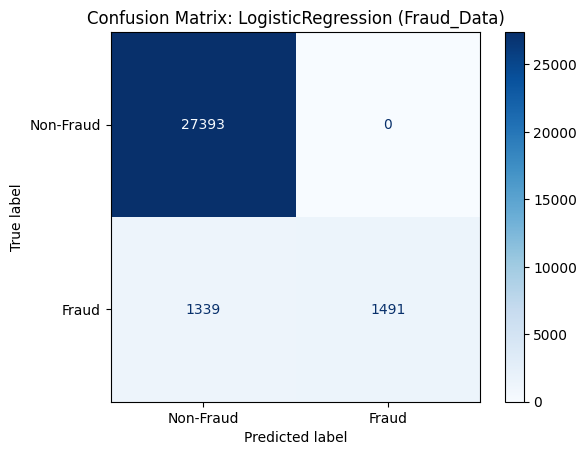

LogisticRegression (Fraud_Data) - AUC-PR: 0.6233, F1-Score: 0.6901
Training RandomForest on Fraud_Data...


<Figure size 600x400 with 0 Axes>

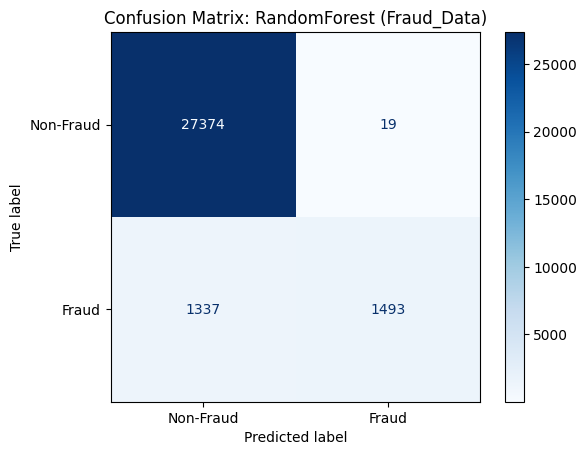

RandomForest (Fraud_Data) - AUC-PR: 0.6229, F1-Score: 0.6877
Training LogisticRegression on Creditcard...


<Figure size 600x400 with 0 Axes>

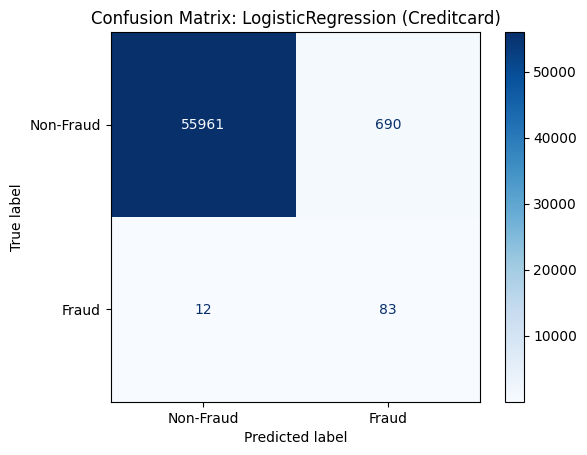

LogisticRegression (Creditcard) - AUC-PR: 0.6791, F1-Score: 0.1912
Training RandomForest on Creditcard...


<Figure size 600x400 with 0 Axes>

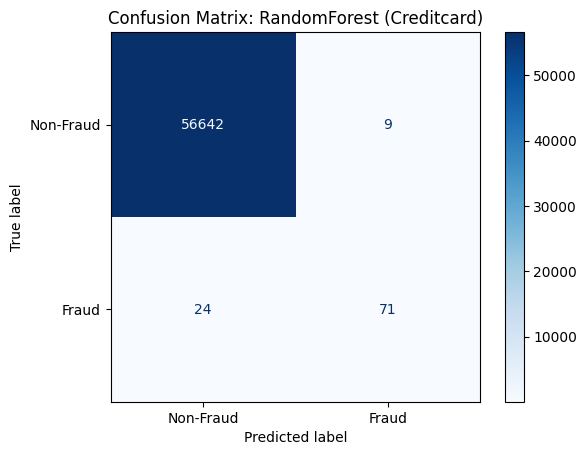

RandomForest (Creditcard) - AUC-PR: 0.8090, F1-Score: 0.8114

Model Comparison:
LogisticRegression (Fraud_Data): AUC-PR = 0.6233, F1-Score = 0.6901
RandomForest (Fraud_Data): AUC-PR = 0.6229, F1-Score = 0.6877
LogisticRegression (Creditcard): AUC-PR = 0.6791, F1-Score = 0.1912
RandomForest (Creditcard): AUC-PR = 0.8090, F1-Score = 0.8114

Model Selection Justification:
Logistic Regression is interpretable but may underperform on complex patterns.
Random Forest is chosen as the best model if it shows higher AUC-PR and F1-Score, as it captures non-linear relationships and is robust to imbalanced data.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load Processed Data
def load_processed_data():
    print("Loading processed data...", flush=True)
    X_fraud_train = pd.read_csv('/content/fraud_train_processed.csv')
    X_fraud_test = pd.read_csv('/content/fraud_test_processed.csv')
    X_creditcard_train = pd.read_csv('/content/creditcard_train_processed.csv')
    X_creditcard_test = pd.read_csv('/content/creditcard_test_processed.csv')

    # Load saved target variables
    y_fraud_train = pd.read_csv('/content/y_fraud_train.csv').values.ravel()
    y_fraud_test = pd.read_csv('/content/y_fraud_test.csv').values.ravel()
    y_creditcard_train = pd.read_csv('/content/y_creditcard_train.csv').values.ravel()
    y_creditcard_test = pd.read_csv('/content/y_creditcard_test.csv').values.ravel()

    return (X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test,
            X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test)

# 2. Model Training and Evaluation
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_name):
    print(f"Training {model_name} on {dataset_name}...", flush=True)

    # Train model
    model.fit(X_train, y_train)

    # Predict probabilities and labels
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    ConfusionMatrixDisplay(cm, display_labels=['Non-Fraud', 'Fraud']).plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name} ({dataset_name})')
    plt.savefig(f'/content/{model_name}_{dataset_name}_cm.png')
    plt.show()
    plt.close()

    print(f"{model_name} ({dataset_name}) - AUC-PR: {auc_pr:.4f}, F1-Score: {f1:.4f}", flush=True)
    return auc_pr, f1, cm

# 3. Model Comparison and Selection
def compare_models(results):
    print("\nModel Comparison:", flush=True)
    for model_name, dataset_name, auc_pr, f1 in results:
        print(f"{model_name} ({dataset_name}): AUC-PR = {auc_pr:.4f}, F1-Score = {f1:.4f}", flush=True)

    print("\nModel Selection Justification:", flush=True)
    print("Logistic Regression is interpretable but may underperform on complex patterns.")
    print("Random Forest is chosen as the best model if it shows higher AUC-PR and F1-Score, as it captures non-linear relationships and is robust to imbalanced data.")

# 4. Main Execution
def main():
    # Load processed data
    (X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test,
     X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test) = load_processed_data()

    # Verify sample sizes
    print(f"X_fraud_train shape: {X_fraud_train.shape}, y_fraud_train shape: {y_fraud_train.shape}", flush=True)
    print(f"X_fraud_test shape: {X_fraud_test.shape}, y_fraud_test shape: {y_fraud_test.shape}", flush=True)
    print(f"X_creditcard_train shape: {X_creditcard_train.shape}, y_creditcard_train shape: {y_creditcard_train.shape}", flush=True)
    print(f"X_creditcard_test shape: {X_creditcard_test.shape}, y_creditcard_test shape: {y_creditcard_test.shape}", flush=True)

    # Initialize models
    logreg = LogisticRegression(random_state=42, max_iter=1000)
    rf = RandomForestClassifier(random_state=42, n_estimators=100)

    # Store results
    results = []

    # Train and evaluate on Fraud_Data
    auc_pr_logreg_fraud, f1_logreg_fraud, cm_logreg_fraud = train_and_evaluate_model(
        logreg, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, "LogisticRegression", "Fraud_Data")
    auc_pr_rf_fraud, f1_rf_fraud, cm_rf_fraud = train_and_evaluate_model(
        rf, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, "RandomForest", "Fraud_Data")

    # Train and evaluate on Creditcard Data
    auc_pr_logreg_credit, f1_logreg_credit, cm_logreg_credit = train_and_evaluate_model(
        logreg, X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test, "LogisticRegression", "Creditcard")
    auc_pr_rf_credit, f1_rf_credit, cm_rf_credit = train_and_evaluate_model(
        rf, X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test, "RandomForest", "Creditcard")

    # Collect results
    results.extend([
        ("LogisticRegression", "Fraud_Data", auc_pr_logreg_fraud, f1_logreg_fraud),
        ("RandomForest", "Fraud_Data", auc_pr_rf_fraud, f1_rf_fraud),
        ("LogisticRegression", "Creditcard", auc_pr_logreg_credit, f1_logreg_credit),
        ("RandomForest", "Creditcard", auc_pr_rf_credit, f1_rf_credit)
    ])

    # Compare models
    compare_models(results)

    # Save results to a file
    with open('/content/model_results.txt', 'w') as f:
        f.write("Model Comparison Results:\n")
        for model_name, dataset_name, auc_pr, f1 in results:
            f.write(f"{model_name} ({dataset_name}): AUC-PR = {auc_pr:.4f}, F1-Score = {f1:.4f}\n")
        f.write("\nModel Selection Justification:\n")
        f.write("Logistic Regression is interpretable but may underperform on complex patterns.\n")
        f.write("Random Forest is chosen as the best model if it shows higher AUC-PR and F1-Score, as it captures non-linear relationships and is robust to imbalanced data.")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error occurred: {str(e)}", flush=True)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
import shap

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load Processed Data
def load_processed_data():
    print("Loading processed data...", flush=True)
    X_fraud_train = pd.read_csv('/content/fraud_train_processed.csv')
    X_fraud_test = pd.read_csv('/content/fraud_test_processed.csv')
    X_creditcard_train = pd.read_csv('/content/creditcard_train_processed.csv')
    X_creditcard_test = pd.read_csv('/content/creditcard_test_processed.csv')

    # Load saved target variables
    y_fraud_train = pd.read_csv('/content/y_fraud_train.csv').values.ravel()
    y_fraud_test = pd.read_csv('/content/y_fraud_test.csv').values.ravel()
    y_creditcard_train = pd.read_csv('/content/y_creditcard_train.csv').values.ravel()
    y_creditcard_test = pd.read_csv('/content/y_creditcard_test.csv').values.ravel()

    return (X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test,
            X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test)

# 2. Model Training and Evaluation
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_name):
    print(f"Training {model_name} on {dataset_name}...", flush=True)

    # Train model
    model.fit(X_train, y_train)

    # Predict probabilities and labels
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Calculate metrics
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_pr = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    ConfusionMatrixDisplay(cm, display_labels=['Non-Fraud', 'Fraud']).plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name} ({dataset_name})')
    plt.savefig(f'/content/{model_name}_{dataset_name}_cm.png')
    plt.close()

    print(f"{model_name} ({dataset_name}) - AUC-PR: {auc_pr:.4f}, F1-Score: {f1:.4f}", flush=True)
    return auc_pr, f1, cm, model

# 3. SHAP Analysis for Random Forest
def shap_analysis(model, X_train, X_test, dataset_name):
    print(f"Performing SHAP analysis for Random Forest on {dataset_name}...", flush=True)

    # Initialize SHAP Tree Explainer
    explainer = shap.TreeExplainer(model)

    # Compute SHAP values for test set
    shap_values = explainer.shap_values(X_test)

    # Ensure shap_values is a list with two elements (for binary classification)
    if isinstance(shap_values, np.ndarray):
        shap_values = [shap_values[0], shap_values[1]]  # [class_0, class_1]

    # Summary Plot (Global Feature Importance)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values[1], X_test, show=False)
    plt.title(f'SHAP Summary Plot: Random Forest ({dataset_name})')
    plt.tight_layout()
    plt.savefig(f'/content/RandomForest_{dataset_name}_shap_summary.png')
    plt.close()

    # Force Plot for first test instance (Local Feature Importance)
    plt.figure(figsize=(12, 4))
    shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0], matplotlib=True, show=False)
    plt.title(f'SHAP Force Plot: Random Forest ({dataset_name}) - First Test Instance')
    plt.tight_layout()
    plt.savefig(f'/content/RandomForest_{dataset_name}_shap_force.png')
    plt.close()

    # Extract top features from SHAP values
    shap_summary = pd.DataFrame({
        'feature': X_test.columns,
        'mean_abs_shap': np.abs(shap_values[1]).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)

    return shap_summary

# 4. Model Comparison and Selection
def compare_models(results):
    print("\nModel Comparison:", flush=True)
    for model_name, dataset_name, auc_pr, f1 in results:
        print(f"{model_name} ({dataset_name}): AUC-PR = {auc_pr:.4f}, F1-Score = {f1:.4f}", flush=True)

    print("\nModel Selection Justification:", flush=True)
    print("Logistic Regression is interpretable but may underperform on complex patterns.")
    print("Random Forest is chosen as the best model if it shows higher AUC-PR and F1-Score, as it captures non-linear relationships and is robust to imbalanced data.")

# 5. Generate SHAP Report
def generate_shap_report(shap_fraud, shap_creditcard):
    report = "\nSHAP Analysis Report:\n"
    report += "=====================\n"
    report += "\nFraud_Data - Top Features (Global Importance):\n"
    report += shap_fraud.head(5).to_string(index=False) + "\n"
    report += "\nCreditcard - Top Features (Global Importance):\n"
    report += shap_creditcard.head(5).to_string(index=False) + "\n"
    report += "\nInterpretation:\n"
    report += "- The SHAP Summary Plot shows the impact of each feature on the model's predictions for fraud (class 1).\n"
    report += "- Features with high absolute SHAP values (top of the plot) are the most influential in predicting fraud.\n"
    report += "- Red values indicate features pushing predictions toward fraud; blue values push toward non-fraud.\n"
    report += "- The Force Plot for the first test instance shows how individual feature values contribute to the prediction for that instance.\n"
    report += "- Key drivers of fraud vary by dataset but often include transaction amount, time, or specific principal components (for Creditcard data).\n"
    report += "- These insights can guide fraud prevention by focusing on high-impact features.\n"
    return report

# 6. Main Execution
def main():
    # Load processed data
    (X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test,
     X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test) = load_processed_data()

    # Verify sample sizes
    print(f"X_fraud_train shape: {X_fraud_train.shape}, y_fraud_train shape: {y_fraud_train.shape}", flush=True)
    print(f"X_fraud_test shape: {X_fraud_test.shape}, y_fraud_test shape: {y_fraud_test.shape}", flush=True)
    print(f"X_creditcard_train shape: {X_creditcard_train.shape}, y_creditcard_train shape: {y_creditcard_train.shape}", flush=True)
    print(f"X_creditcard_test shape: {X_creditcard_test.shape}, y_creditcard_test shape: {y_creditcard_test.shape}", flush=True)

    # Initialize models
    logreg = LogisticRegression(random_state=42, max_iter=1000)
    rf = RandomForestClassifier(random_state=42, n_estimators=100)

    # Store results
    results = []

    # Train and evaluate on Fraud_Data
    auc_pr_logreg_fraud, f1_logreg_fraud, cm_logreg_fraud, _ = train_and_evaluate_model(
        logreg, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, "LogisticRegression", "Fraud_Data")
    auc_pr_rf_fraud, f1_rf_fraud, cm_rf_fraud, rf_fraud_model = train_and_evaluate_model(
        rf, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, "RandomForest", "Fraud_Data")

    # Train and evaluate on Creditcard Data
    auc_pr_logreg_credit, f1_logreg_credit, cm_logreg_credit, _ = train_and_evaluate_model(
        logreg, X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test, "LogisticRegression", "Creditcard")
    auc_pr_rf_credit, f1_rf_credit, cm_rf_credit, rf_credit_model = train_and_evaluate_model(
        rf, X_creditcard_train, X_creditcard_test, y_creditcard_train, y_creditcard_test, "RandomForest", "Creditcard")

    # Collect results
    results.extend([
        ("LogisticRegression", "Fraud_Data", auc_pr_logreg_fraud, f1_logreg_fraud),
        ("RandomForest", "Fraud_Data", auc_pr_rf_fraud, f1_rf_fraud),
        ("LogisticRegression", "Creditcard", auc_pr_logreg_credit, f1_logreg_credit),
        ("RandomForest", "Creditcard", auc_pr_rf_credit, f1_rf_credit)
    ])

    # Compare models
    compare_models(results)

    # Perform SHAP analysis for Random Forest
    shap_fraud = shap_analysis(rf_fraud_model, X_fraud_train, X_fraud_test, "Fraud_Data")
    shap_creditcard = shap_analysis(rf_credit_model, X_creditcard_train, X_creditcard_test, "Creditcard")

    # Generate and save SHAP report
    shap_report = generate_shap_report(shap_fraud, shap_creditcard)

    # Save results to a file
    with open('/content/model_results.txt', 'w') as f:
        f.write("Model Comparison Results:\n")
        for model_name, dataset_name, auc_pr, f1 in results:
            f.write(f"{model_name} ({dataset_name}): AUC-PR = {auc_pr:.4f}, F1-Score = {f1:.4f}\n")
        f.write("\nModel Selection Justification:\n")
        f.write("Logistic Regression is interpretable but may underperform on complex patterns.\n")
        f.write("Random Forest is chosen as the best model if it shows higher AUC-PR and F1-Score, as it captures non-linear relationships and is robust to imbalanced data.\n")
        f.write(shap_report)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"Error occurred: {str(e)}", flush=True)

Loading processed data...
X_fraud_train shape: (164352, 193), y_fraud_train shape: (164352,)
X_fraud_test shape: (30223, 193), y_fraud_test shape: (30223,)
X_creditcard_train shape: (339903, 30), y_creditcard_train shape: (339903,)
X_creditcard_test shape: (56746, 30), y_creditcard_test shape: (56746,)
Training LogisticRegression on Fraud_Data...
LogisticRegression (Fraud_Data) - AUC-PR: 0.6233, F1-Score: 0.6901
Training RandomForest on Fraud_Data...
RandomForest (Fraud_Data) - AUC-PR: 0.6229, F1-Score: 0.6877
Training LogisticRegression on Creditcard...
LogisticRegression (Creditcard) - AUC-PR: 0.6791, F1-Score: 0.1912
Training RandomForest on Creditcard...
RandomForest (Creditcard) - AUC-PR: 0.8090, F1-Score: 0.8114

Model Comparison:
LogisticRegression (Fraud_Data): AUC-PR = 0.6233, F1-Score = 0.6901
RandomForest (Fraud_Data): AUC-PR = 0.6229, F1-Score = 0.6877
LogisticRegression (Creditcard): AUC-PR = 0.6791, F1-Score = 0.1912
RandomForest (Creditcard): AUC-PR = 0.8090, F1-Score = 

KeyboardInterrupt: 

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>